In [1]:
%reset -f
from cProfile import label
from email import message_from_binary_file
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
from IPython.core.pylabtools import figsize
from spyder_kernels.utils.lazymodules import pandas

pv.set_jupyter_backend('server')

#from pyqtgraph import plots


In [2]:
def GetInfo(filePath):
    import h5py
    All={}
    subVal={}
    subsubVal={}
    f=h5py.File(filePath,"r")
    
    for folder in f:
        subVal={}
        for table in f[folder]:
            subsubVal={}
            for field in f[folder][table].dtype.fields.keys():
                subsubVal[field]=f[folder][table][field]
            subVal[table]=subsubVal
        All[folder]=subVal
    f.close()    
    return All

In [3]:
import h5py
from concurrent.futures import ThreadPoolExecutor

def process_folder(folder, data):
    subVal = {}
    for table in data[folder]:
        subsubVal = {field: data[folder][table][field] for field in data[folder][table].dtype.fields.keys()}
        subVal[table] = subsubVal
    return folder, subVal

def GetInfoM(filePath):
    All = {}
    with h5py.File(filePath, "r") as f:
        data = {folder: {table: f[folder][table][:] for table in f[folder]} for folder in f}
        with ThreadPoolExecutor(max_workers=20) as executor:
            results = list(executor.map(lambda folder: process_folder(folder, data), data.keys()))
        All = dict(results)
    return All

In [4]:
def isFileThere(f):
    try:
        return np.load(f)
    except FileNotFoundError:
        return -1


        

In [5]:
### Get all
import os
user="rice"
folder="OpticksTest/gdml_det/ALL0_no_opticks_event_name/"

files=os.listdir(f"/tmp/{user}/opticks/GEOM/{folder}/")

Hits={}
Steps={}
Records={}
Photons={}
GenStep={}
print(files)
#All=sorted(files)[:-2]
All=sorted(files)
print (f" All the event files {All}")
Count=0


for i in All:
    print(i)
    record=isFileThere(f"/tmp/{user}/opticks/GEOM/{folder}/{i}/record.npy")
    photon=isFileThere(f"/tmp/{user}/opticks/GEOM/{folder}/{i}/photon.npy")
    hit=isFileThere(f"/tmp/{user}/opticks/GEOM/{folder}/{i}/hit.npy")
    gen=isFileThere(f"/tmp/{user}/opticks/GEOM/{folder}/{i}/genstep.npy")
    
    if(len(hit)>1):
        Hits[Count]=hit
    if(len(record)>1):    
        Records[Count]=record
    if(len(photon)>1):    
        Photons[Count]=photon
    if(len(gen)>1):
        GenStep[Count]=gen
    if(len(record)>1):
        Steps[Count]=record[:,0,0,:3] ## Position and time of first 5 steps
    Count=Count+1



['A000']
 All the event files ['A000']
A000


In [6]:
#Conversions
boundary_  = lambda p:p.view(np.uint32) >> 16    
flag_      = lambda p:p.view(np.uint32) & 0xffff

identity_ = lambda p:p.view(np.uint32)[3,1]   
primIdx_   = lambda p:identity_(p) >> 16  
instanceId_  = lambda p:identity_(p) & 0xffff  

idx_      = lambda p:p.view(np.uint32)[3,2] & 0x7fffffff
orient_   = lambda p:p.view(np.uint32)[3,2] >> 31

flagmask_ = lambda p:p.view(np.uint32)


class PhotonFlag:
    CERENKOV = 1 << 0
    SCINTILLATION = 1 << 1
    MISS = 1 << 2
    BULK_ABSORB = 1 << 3
    BULK_REEMIT = 1 << 4
    BULK_SCATTER = 1 << 5
    SURFACE_DETECT = 1 << 6
    SURFACE_ABSORB = 1 << 7
    SURFACE_DREFLECT = 1 << 8
    SURFACE_SREFLECT = 1 << 9
    BOUNDARY_REFLECT = 1 << 10
    BOUNDARY_TRANSMIT = 1 << 11
    TORCH = 1 << 12
    NAN_ABORT = 1 << 13
    EFFICIENCY_CULL = 1 << 14
    EFFICIENCY_COLLECT = 1 << 15
    __NATURAL = 1 << 16
    __MACHINERY = 1 << 17
    __EMITSOURCE = 1 << 18
    PRIMARYSOURCE = 1 << 19
    GENSTEPSOURCE = 1 << 20
    DEFER_FSTRACKINFO = 1 << 21
    
class PhotonFlagNames:
    ZERO = "."
    CERENKOV = "CERENKOV"
    SCINTILLATION = "SCINTILLATION"
    TORCH = "TORCH"
    MISS = "MISS"
    BULK_ABSORB = "BULK_ABSORB"
    BULK_REEMIT = "BULK_REEMIT"
    BULK_SCATTER = "BULK_SCATTER"
    SURFACE_DETECT = "SURFACE_DETECT"
    SURFACE_ABSORB = "SURFACE_ABSORB"
    SURFACE_DREFLECT = "SURFACE_DREFLECT"
    SURFACE_SREFLECT = "SURFACE_SREFLECT"
    BOUNDARY_REFLECT = "BOUNDARY_REFLECT"
    BOUNDARY_TRANSMIT = "BOUNDARY_TRANSMIT"
    NAN_ABORT = "NAN_ABORT"
    EFFICIENCY_CULL = "EFFICIENCY_CULL"
    EFFICIENCY_COLLECT = "EFFICIENCY_COLLECT"
    BAD_FLAG = "BAD_FLAG"
    DEFER_FSTRACKINFO = "DEFER_FSTRACKINFO"

def GetFlag(flag):
    particle_event_types = {
        0: PhotonFlagNames.ZERO,
        PhotonFlag.CERENKOV: PhotonFlagNames.CERENKOV,
        PhotonFlag.SCINTILLATION: PhotonFlagNames.SCINTILLATION,
        PhotonFlag.MISS: PhotonFlagNames.MISS,
        PhotonFlag.BULK_ABSORB: PhotonFlagNames.BULK_ABSORB,
        PhotonFlag.BULK_REEMIT: PhotonFlagNames.BULK_REEMIT,
        PhotonFlag.BULK_SCATTER: PhotonFlagNames.BULK_SCATTER,
        PhotonFlag.SURFACE_DETECT: PhotonFlagNames.SURFACE_DETECT,
        PhotonFlag.SURFACE_ABSORB: PhotonFlagNames.SURFACE_ABSORB,
        PhotonFlag.SURFACE_DREFLECT: PhotonFlagNames.SURFACE_DREFLECT,
        PhotonFlag.SURFACE_SREFLECT: PhotonFlagNames.SURFACE_SREFLECT,
        PhotonFlag.BOUNDARY_REFLECT: PhotonFlagNames.BOUNDARY_REFLECT,
        PhotonFlag.BOUNDARY_TRANSMIT: PhotonFlagNames.BOUNDARY_TRANSMIT,
        PhotonFlag.TORCH: PhotonFlagNames.TORCH,
        PhotonFlag.NAN_ABORT: PhotonFlagNames.NAN_ABORT,
        PhotonFlag.EFFICIENCY_COLLECT: PhotonFlagNames.EFFICIENCY_COLLECT,
        PhotonFlag.EFFICIENCY_CULL: PhotonFlagNames.EFFICIENCY_CULL,
        PhotonFlag.DEFER_FSTRACKINFO: PhotonFlagNames.DEFER_FSTRACKINFO
    }
    if(flag in particle_event_types):
        return particle_event_types[flag]
    else:
        return particle_event_types.get(flag, PhotonFlagNames.BAD_FLAG)
    

In [7]:
def GetPhotonsPositionsFromRecord(Rec,Event,Mask):
    xR=Rec[Event][:,:,0,0].ravel()[Mask]
    yR=Rec[Event][:,:,0,1].ravel()[Mask]
    zR=Rec[Event][:,:,0,2].ravel()[Mask]

    return np.stack((xR.reshape(-1),yR.reshape(-1),zR.reshape(-1)),axis=1)


In [8]:
### Record Photon
## NumPhoton,boundaries,properties(position,momentum),(x,y,z,t)

import seaborn as sns
Event=0
Flags=Records[Event][:,:,3,0]
recPhotons=Records[Event][:,:,0,:3]

Boundaries=np.array(boundary_(Records[0][:,:,3,0])).ravel() 
GetFlagVector=np.vectorize(GetFlag)
FLg=GetFlagVector(flag_(Flags)).ravel()

#ZeroMask=(FLg!= PhotonFlagNames.ZERO) & (FLg != PhotonFlagNames.MISS) & (FLg != PhotonFlagNames.SCINTILLATION) & (FLg != PhotonFlagNames.NAN_ABORT)
#FLg=FLg[ZeroMask]
#Boundaries=Boundaries[ZeroMask]
BoundaryMask=FLg== (PhotonFlagNames.SURFACE_DETECT) 
TransitPhotons=GetPhotonsPositionsFromRecord(Records,Event,BoundaryMask)
DetectedPhotonsMask=FLg== (PhotonFlagNames.SURFACE_DETECT)
DetectedPhotons=GetPhotonsPositionsFromRecord(Records,Event,BoundaryMask)

print(np.unique(FLg))
print(Boundaries[BoundaryMask],len(Boundaries))
print(FLg[BoundaryMask],len(Boundaries))
print(Records[Event][:,:,0,0].ravel(),len(Records[Event][:,:,0,0].ravel()))


Dict={"Flags":FLg[BoundaryMask],"Bnd":Boundaries[BoundaryMask]}
plt.figure(figsize=(25,25))
#sns.boxplot(data=Dict,x="Flags",y="Bnd",hue="Flags",whis=(0,100))

pl=pv.Plotter()
#pl.add_mesh(TransitPhotons,color="red",opacity=0.9,label="Photons Pass Through")
pl.add_mesh(DetectedPhotons,color="green",opacity=0.9,label="Detected")

    
pl.add_legend()     
pl.show_grid()

pl.show()

del pl


['.' 'BOUNDARY_REFLECT' 'BOUNDARY_TRANSMIT' 'SCINTILLATION'
 'SURFACE_ABSORB' 'SURFACE_DETECT' 'SURFACE_SREFLECT']
[399 414 501 ... 483 458 389] 3767072
['SURFACE_DETECT' 'SURFACE_DETECT' 'SURFACE_DETECT' ... 'SURFACE_DETECT'
 'SURFACE_DETECT' 'SURFACE_DETECT'] 3767072
[2024.5017 3633.7605 3633.9207 ...    0.        0.        0.    ] 3767072


Widget(value='<iframe src="http://localhost:46345/index.html?ui=P_0x7f19a4430590_0&reconnect=auto" class="pyvi…

<Figure size 2500x2500 with 0 Axes>

In [9]:
## Related to Photons
Event=0
xphoton = Photons[Event][:,0,0]
yphoton = Photons[Event][:,0,1]
zphoton = Photons[Event][:,0,2]
tphoton = Photons[Event][:,0,3]
momx = Photons[Event][:,1,0]
momy = Photons[Event][:,1,1]
momz = Photons[Event][:,1,2]
iindex = Photons[Event][:,1,3]
polx = Photons[Event][:,2,0]
poly = Photons[Event][:,2,1]
polz = Photons[Event][:,2,2]
wavelength = Photons[Event][:,2,3]
boundary_flag=Photons[Event][:,3,0]
identity=Photons[Event][:,3,1]
orientidx=Photons[Event][:,3,2]
flagmask=Photons[Event][:,3,0]
GetFlagVector=np.vectorize(GetFlag)
print(np.unique(GetFlagVector(flag_(flagmask))))
BndMask=GetFlagVector(flag_(flagmask))==PhotonFlagNames.SURFACE_DETECT
UniqueBnds=np.unique(boundary_(flagmask)[BndMask])                      
print(UniqueBnds)
print(len(UniqueBnds))

## Related to Photons

['BOUNDARY_REFLECT' 'BOUNDARY_TRANSMIT' 'SURFACE_ABSORB' 'SURFACE_DETECT']
[ 15  17  24  25  29  31  32  35  36  40  41  42  44  45  46  50  51  52
  54  55  56  60  61  62  64  67  68  69  73  74  77  78  79  81  83  84
  86  87  88  89  91  92  93  94  96  97  98  99 101 102 103 104 107 108
 109 111 112 113 114 116 118 119 121 122 123 126 127 128 129 131 133 134
 136 137 139 141 142 143 144 146 147 148 149 151 152 153 154 156 157 158
 159 161 162 163 164 166 167 168 169 171 172 173 174 176 177 178 179 181
 182 183 184 186 187 188 189 191 192 193 194 196 197 198 199 201 202 203
 204 206 207 209 211 212 213 214 217 221 222 223 224 226 227 228 229 231
 232 233 234 236 237 238 241 242 243 244 246 248 249 251 253 254 256 257
 258 259 261 262 263 264 266 267 268 269 271 272 273 274 276 277 278 279
 281 282 283 284 286 287 288 289 291 292 293 294 296 297 298 299 301 302
 303 304 306 307 308 309 311 312 313 314 316 319 321 322 323 326 327 328
 329 331 332 333 334 336 337 338 339 341 342 343 

In [10]:
Flags=Records[Event][:,:,3,0]
FLg=GetFlagVector(flag_(Flags)).ravel()

In [11]:

PhMask=(FLg==(PhotonFlagNames.SURFACE_DETECT))
BndNumMask=(boundary_(Flags.ravel()[PhMask])>=14) & (boundary_(Flags.ravel()[PhMask])<=609)
print(np.unique(BndNumMask))
zR=Records[Event][:,:,0,2].ravel()[PhMask][BndNumMask]
#Zmaks=zR<0

[False  True]


In [12]:
print(FLg[PhMask])

['SURFACE_DETECT' 'SURFACE_DETECT' 'SURFACE_DETECT' ... 'SURFACE_DETECT'
 'SURFACE_DETECT' 'SURFACE_DETECT']


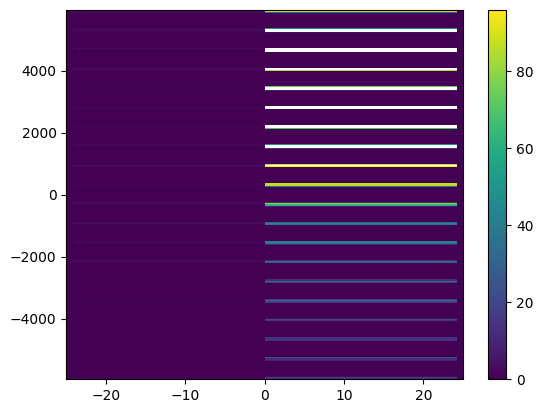

In [13]:

xR=Records[Event][:,:,0,0].ravel()[PhMask][BndNumMask]
yR=Records[Event][:,:,0,1].ravel()[PhMask][BndNumMask]
zR=Records[Event][:,:,0,2].ravel()[PhMask][BndNumMask]
_=plt.hist2d(xR,yR,bins=300,cmin=0,cmax=100)
plt.xlim(-25,25)
#plt.ylim(-10,10)
plt.colorbar()

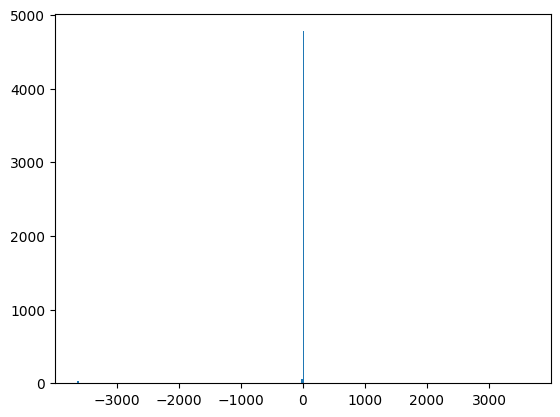

In [14]:
_=plt.hist(xR,bins=300)


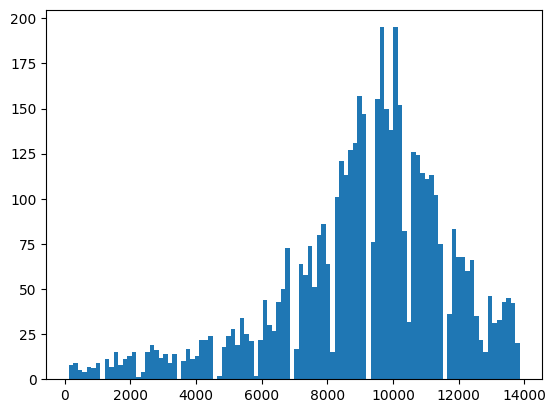

In [15]:
_=plt.hist(zR,bins=100)


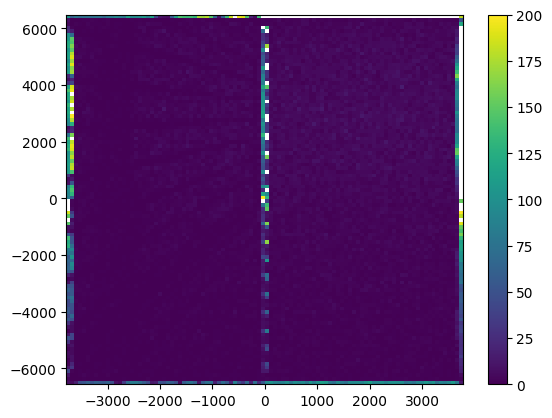

In [16]:
plt.hist2d(xphoton,yphoton,bins=100,cmin=0,cmax=200)
#plt.xlim(-100,100)
#plt.ylim(-222.9,-270)
plt.colorbar()

In [17]:
len(zphoton[(zphoton>-260) & (zphoton<-220)])

23

In [18]:
## Related to Photons
Event=0
if(len(Hits)>1):
    xhit = Hits[Event][:,0,0]
    yhit = Hits[Event][:,0,1]
    zhit = Hits[Event][:,0,2]
    thit = Hits[Event][:,0,3]
    momx_hit = Hits[Event][:,1,0]
    momy_hit = Hits[Event][:,1,1]
    momz_hit = Hits[Event][:,1,2]
    iindex_hit = Hits[Event][:,1,3]
    polx_hit = Hits[Event][:,2,0]
    poly_hit = Hits[Event][:,2,1]
    polz_hit = Hits[Event][:,2,2]
    wavelength_hit = Hits[Event][:,2,3]
    boundary_flag_hit=boundary_(Hits[Event][:,3,0])
    identity_hit=Hits[Event][:,3,1]
    orientidx_hit=Hits[Event][:,3,2]
    flagmask_hit=Hits[Event][:,3,3]
    plt.hist2d(zhit,yhit)

In [19]:
### For Record

## Related to Photons
xphoton = record[:,0,0]
yphoton = record[:,0,1]
zphoton = record[:,0,2]
tphoton = record[:,0,3]
momx = record[:,1,0]
momy = record[:,1,1]
momz = record[:,1,2]
iindex = record[:,1,3]
polx = record[:,2,0]
poly = record[:,2,1]
polz = record[:,2,2]
wavelength = record[:,2,3]
boundary_flag=record[:,3,0]
identity=record[:,3,1]
orientidx=record[:,3,2]
flagmask=record[:,3,3]

In [20]:
### Record Photon
## NumPhoton,boundaries,properties(position,momentum),(x,y,z,t)

import seaborn as sns
Event=0
Flags=Records[Event][:,:,3,0]
recPhotons=Records[Event][:,:,0,:3]

Boundaries=np.array(boundary_(Records[0][:,:,3,0])).ravel() 
GetFlagVector=np.vectorize(GetFlag)
FLg=GetFlagVector(flag_(Flags)).ravel()

#ZeroMask=(FLg!= PhotonFlagNames.ZERO) & (FLg != PhotonFlagNames.MISS) & (FLg != PhotonFlagNames.SCINTILLATION) & (FLg != PhotonFlagNames.NAN_ABORT)
#FLg=FLg[ZeroMask]
#Boundaries=Boundaries[ZeroMask]
BoundaryMask=FLg== (PhotonFlagNames.SURFACE_DETECT) 
TransitPhotons=GetPhotonsPositionsFromRecord(Records,Event,BoundaryMask)
DetectedPhotonsMask=FLg== (PhotonFlagNames.SURFACE_DETECT)
DetectedPhotons=GetPhotonsPositionsFromRecord(Records,Event,BoundaryMask)

print(np.unique(FLg))
print(Boundaries[BoundaryMask],len(Boundaries))
print(FLg[BoundaryMask],len(Boundaries))
print(Records[Event][:,:,0,0].ravel(),len(Records[Event][:,:,0,0].ravel()))


Dict={"Flags":FLg[BoundaryMask],"Bnd":Boundaries[BoundaryMask]}
plt.figure(figsize=(25,25))
#sns.boxplot(data=Dict,x="Flags",y="Bnd",hue="Flags",whis=(0,100))

pl=pv.Plotter()
#pl.add_mesh(TransitPhotons,color="red",opacity=0.9,label="Photons Pass Through")
pl.add_mesh(DetectedPhotons,color="green",opacity=0.9,label="Detected")

    
pl.add_legend()     
pl.show_grid()

pl.show()

del pl


['.' 'BOUNDARY_REFLECT' 'BOUNDARY_TRANSMIT' 'SCINTILLATION'
 'SURFACE_ABSORB' 'SURFACE_DETECT' 'SURFACE_SREFLECT']
[399 414 501 ... 483 458 389] 3767072
['SURFACE_DETECT' 'SURFACE_DETECT' 'SURFACE_DETECT' ... 'SURFACE_DETECT'
 'SURFACE_DETECT' 'SURFACE_DETECT'] 3767072
[2024.5017 3633.7605 3633.9207 ...    0.        0.        0.    ] 3767072


Widget(value='<iframe src="http://localhost:46345/index.html?ui=P_0x7f199c3fe850_1&reconnect=auto" class="pyvi…

<Figure size 2500x2500 with 0 Axes>